In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, LabelBinarizer, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix)
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

df = pd.read_csv('coffee_survey_processed.csv')

X = df.drop(columns='roast_level')
y = df['roast_level']

df

,age,cups,expertise,roast_level,favorite,style,caffeine,total_spend,most_paid,most_willing,...,coffee_a_personal_preference,coffee_b_bitterness,coffee_b_acidity,coffee_b_personal_preference,coffee_c_bitterness,coffee_c_acidity,coffee_c_personal_preference,coffee_d_bitterness,coffee_d_acidity,coffee_d_personal_preference
0,<18,2.0,NaN,Light,Other,Full Bodied,Full caffeine,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25-34,1.0,7.0,Light,Pourover,Fruity,Full caffeine,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,<18,3.0,10.0,Light,Pourover,Bright,Full caffeine,>$100,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,>65,3.0,7.0,Light,Cortado,Fruity,Full caffeine,NaN,NaN,NaN,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
4,25-34,1.0,6.0,Medium,Regular drip coffee,Sweet,Full caffeine,$40-$60,NaN,NaN,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3935,>65,2.0,2.0,Medium,Regular drip coffee,Chocolatey,Full caffeine,$20-$40,$6-$8,$4-$6,...,5.0,2.0,2.0,3.0,2.0,2.0,4.0,5.0,5.0,1.0
3936,>65,2.0,2.0,Light,Regular drip coffee,Nutty,Full caffeine,$20-$40,$4-$6,$2-$4,...,4.0,3.0,3.0,2.0,4.0,3.0,2.0,4.0,3.0,2.0
3937,18-24,1.0,5.0,Light,Latte,Sweet,Full caffeine,$40-$60,$8-$10,More than $20,...,3.0,5.0,3.0,4.0,3.0,1.0,1.0,1.0,4.0,5.0
3938,25-34,2.0,6.0,Medium,Iced coffee,Nutty,Full caffeine,$20-$40,$4-$6,$8-$10,...,4.0,3.0,2.0,3.0,2.0,3.0,3.0,2.0,5.0,2.0


In [14]:
# lets define an inherent ordering for ordinal columns

orderings = [
    ['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '>65'], # age
    # ['Light', 'Medium', 'Dark'], # roast_level dont need to rank target
    ['Decaf', 'Half caff', 'Full caffeine'], # caffeine
    ['Less than high school', 'High school graduate', 'Some college or associate\'s degree', 'Bachelor\'s degree', 'Master\'s degree', 'Doctorate or professional degree'], # education_level
    ['<$20', '$20-$40', '$40-$60', '$60-$80', '$80-$100', '>$100'], # total_spend
    ['Less than $2', '$2-$4', '$4-$6', '$6-$8', '$8-$10', '$10-$15', '$15-$20', 'More than $20'], # most_paid
    ['Less than $2', '$2-$4', '$4-$6', '$6-$8', '$8-$10', '$10-$15', '$15-$20', 'More than $20'], # most_willing
    ['Less than $20', '$20-$50', '$50-$100', '$100-$300', '$300-$500', '$500-$1000', 'More than $1,000'], # spent_equipment
]

### XGBoost

=== Cross-Validation Metrics ===
Accuracy: 0.6898 ± 0.0229
Precision: 0.6838 ± 0.0282
Recall: 0.6898 ± 0.0229
F1 Score: 0.6722 ± 0.0229
ROC AUC: 0.8104 ± 0.0099


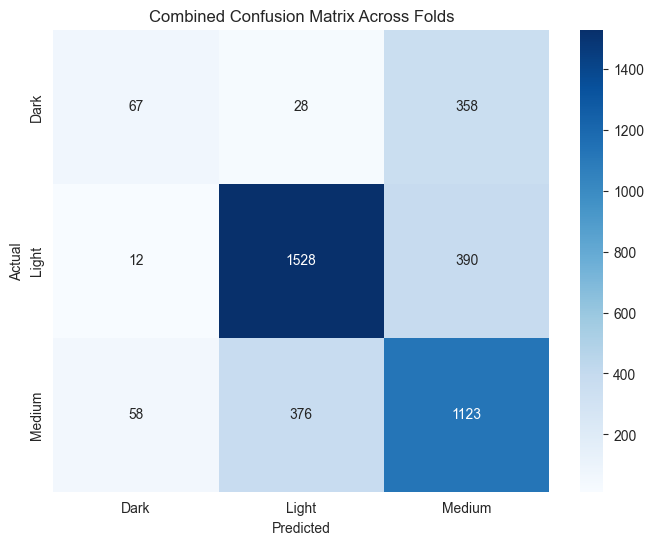

In [15]:

# Encode features
ordinal_columns = ['age', 'caffeine', 'education_level', 'total_spend', 'most_paid', 'most_willing', 'spent_equipment']
numeric_columns = ['cups', 'expertise', 'number_children', 'coffee_a_bitterness',
    'coffee_a_acidity',
    'coffee_a_personal_preference',
    'coffee_b_bitterness',
    'coffee_b_acidity',
    'coffee_b_personal_preference',
    'coffee_c_bitterness',
    'coffee_c_acidity',
    'coffee_c_personal_preference',
    'coffee_d_bitterness',
    'coffee_d_acidity',
    'coffee_d_personal_preference',]
nominal_columns = [
    'style',
    'favorite',
    'wfh',
    'know_source','value_cafe','gender','ethnicity_race','employment_status','political_affiliation',
]

ordinal_imputer = SimpleImputer(strategy='most_frequent')
numeric_imputer = SimpleImputer(strategy='median')
nominal_imputer = SimpleImputer(strategy='most_frequent')

preprocessor = ColumnTransformer([
    ('ord',  Pipeline([('imputer', ordinal_imputer),
                        ('encoder', OrdinalEncoder(categories=orderings))]), ordinal_columns),
    ('nom',  Pipeline([('imputer', nominal_imputer),
                        ('encoder', OneHotEncoder(handle_unknown='ignore'))]), nominal_columns),
    ('num',  Pipeline([('imputer', numeric_imputer)]), numeric_columns)
])

X_encoded = preprocessor.fit_transform(X)
# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# For multi-class ROC AUC
lb = LabelBinarizer()
y_binarized = lb.fit_transform(y_encoded)

# -----------------------------
# 2. Prepare k-fold
# -----------------------------
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Lists to collect per-fold metrics
accuracies, precisions, recalls, f1s, roc_aucs = [], [], [], [], []
cm_total = np.zeros((len(np.unique(y_encoded)), len(np.unique(y_encoded))))

# -----------------------------
# 3. K-Fold training
# -----------------------------
for fold, (train_idx, test_idx) in enumerate(kf.split(X_encoded, y_encoded)):
    X_train, X_test = X_encoded[train_idx], X_encoded[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]
    y_test_bin = y_binarized[test_idx]

    # Create DMatrix for XGBoost CV (optional: early stopping, num_boost_round)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    params = {
        'objective': 'multi:softprob',
        'num_class': len(np.unique(y_encoded)),
        'eval_metric': 'mlogloss'
    }

    # Internal XGBoost CV to determine optimal boosting rounds
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=100,
        nfold=3,                # internal k-fold for boosting
        early_stopping_rounds=10,
        seed=42,
        verbose_eval=False
    )
    best_rounds = len(cv_results)

    # Train model with determined boosting rounds
    model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=len(np.unique(y_encoded)),
        n_estimators=best_rounds,
        eval_metric='mlogloss'
    )
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    # Metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, average='weighted'))
    recalls.append(recall_score(y_test, y_pred, average='weighted'))
    f1s.append(f1_score(y_test, y_pred, average='weighted'))

    # ROC AUC (multi-class, OvR)
    try:
        roc_aucs.append(roc_auc_score(y_test_bin, y_proba, multi_class='ovr'))
    except:
        roc_aucs.append(np.nan)  # fallback if binary/multi-class mismatch

    # Confusion matrix
    cm_total += confusion_matrix(y_test, y_pred)

# -----------------------------
# 4. Report combined metrics
# -----------------------------
print("=== Cross-Validation Metrics ===")
print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1 Score: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
print(f"ROC AUC: {np.nanmean(roc_aucs):.4f} ± {np.nanstd(roc_aucs):.4f}")

# -----------------------------
# 5. Plot combined confusion matrix
# -----------------------------
plt.figure(figsize=(8,6))
sns.heatmap(cm_total.astype(int), annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Combined Confusion Matrix Across Folds')
plt.show()